Snippet to load and visualize the dataset


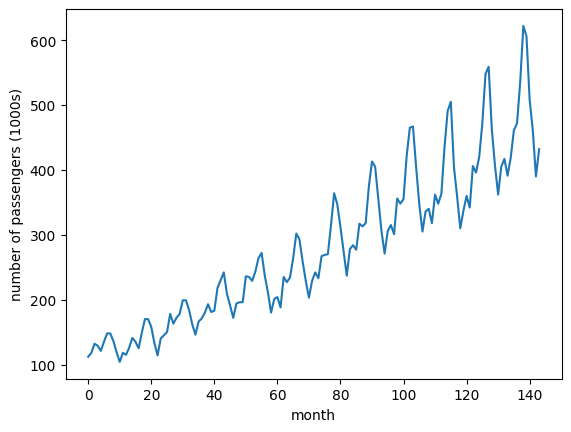

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

##use this only if you didn't download yet the csv file##
##!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

training_set = pd.read_csv('airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values
#print(training_set[0])

plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()

In [2]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]    #the next has to be predicted
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 16   #it is tau in the paper
x, y = sliding_windows(training_data, seq_length)


train_size=len(y) -36            #like in the paper
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

print(training_data.shape)   
print(dataX.shape)          
print(dataY.shape)
print(trainX.shape)               #batch_size, history_length, num_features)
print(trainY.shape)
print(trainX.size(0))

(144, 1)
torch.Size([127, 16, 1])
torch.Size([127, 1])
torch.Size([91, 16, 1])
torch.Size([91, 1])
91


torch.Size([91, 16, 1])
torch.Size([91, 16, 1])


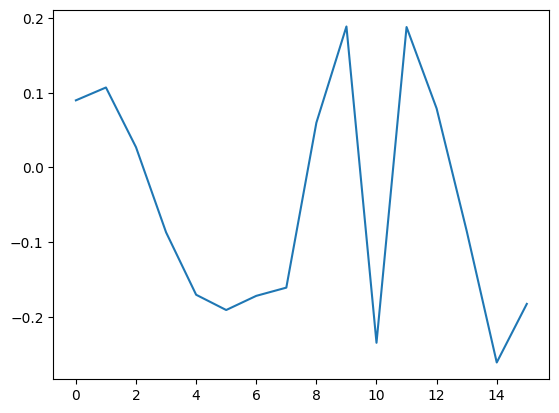

In [11]:
import blocks

compressor=blocks.pool(trainX.size(0))
z=compressor(trainX.reshape((trainX.shape[0],trainX.shape[2],trainX.shape[1]))) #Latent Space
z=z.reshape((z.shape[0],z.shape[2],z.shape[1]))

G=blocks.Generator(z.size(0))
p=G(z)

print(trainX.shape) #batch_size, hidden_length=8, num_features)
print(p.shape)   #batch_size, fake_length=2^(n+3), num_features)
plt.plot(p[1].detach().numpy())

